In [25]:
import numpy as np
import os
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings(action='ignore')

In [26]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [27]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/potato-leaf-disease-dataset/Potato Leaf Disease Dataset in Uncontrolled Environment",
    seed=58,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3076 files belonging to 7 classes.


In [28]:
len(dataset)

97

In [29]:
class_names = dataset.class_names
class_names

['Bacteria', 'Fungi', 'Healthy', 'Nematode', 'Pest', 'Phytopthora', 'Virus']

In [30]:
def get_all_labels(ds):
    labels = []
    for image_batch, labels_batch in ds:
        labels.extend(labels_batch.numpy())
    return labels

In [31]:
labels = get_all_labels(dataset)
# Count the occurrences of each class
class_counts = {class_name: 0 for class_name in class_names}
for label in labels:
    class_counts[class_names[label]] += 1


In [32]:
# Plot the pie chart
import plotly.express as px
import pandas as pd
df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])
fig = px.pie(df, values='Count', names='Class', title='Proportion of Each Observed Category', hole=0.3,width=500, height=500)
fig.show()

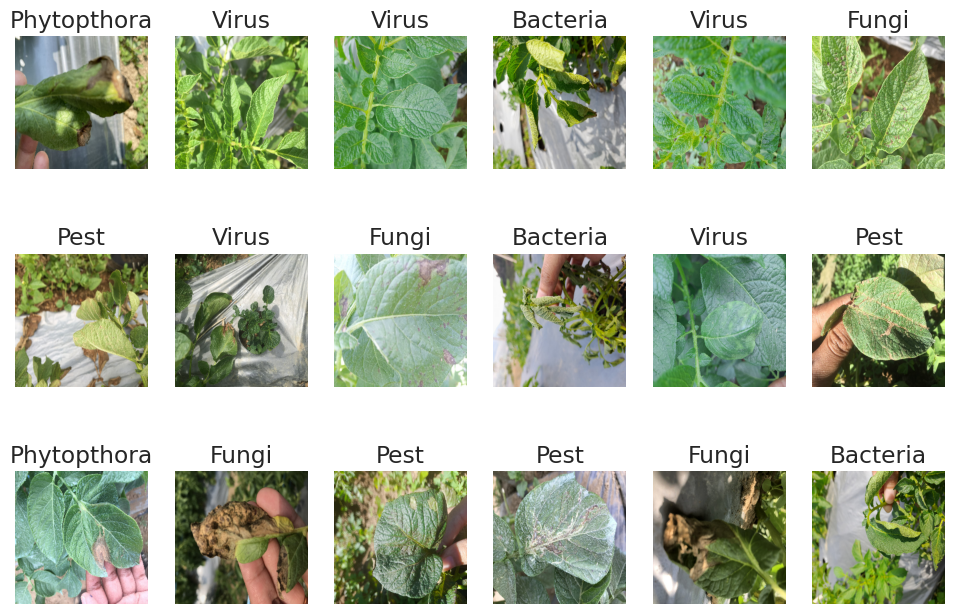

In [33]:
plt.figure(figsize=(12, 8))
for image_batch, labels_batch in dataset.take(1):
    for i in range(18):
        ax = plt.subplot(3,6, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")


In [34]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)


    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [35]:
print(len(train_ds))         #77+11+9=97
print(len(val_ds))
print(len(test_ds))

77
9
11


In [36]:

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [37]:
from tensorflow.keras import layers
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])


In [38]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

# Function to create DenseNet121 model
def create_densenet_model(input_shape):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape[1:])
    base_model.trainable = False
    
    model = Sequential([
        base_model,
        BatchNormalization(),
        Flatten(),
        Dense(264, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(7, activation='softmax')
    ])
    
    return model

# Create the model
model = create_densenet_model(input_shape)

# Build the model (optional, only if needed for some custom layer initialization)
model.build(input_shape=input_shape)




In [39]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (32, 8, 8, 1024)       │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (32, 8, 8, 1024)       │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 65536)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (32, 264)              │    17,301,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (32, 264)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (32, 264)              │         1,056 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (32, 128)              │        33,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (32, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (32, 128)              │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (32, 64)               │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (32, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (32, 64)               │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (32, 7)                │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,387,823 (93.03 MB)

 Trainable params: 17,347,359 (66.17 MB)

 Non-trainable params: 7,040,464 (26.86 MB)

In [40]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [41]:
from tensorflow.keras import mixed_precision

# Disable XLA
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2'

# Use float32 precision
mixed_precision.set_global_policy('float32')

In [42]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=0'


In [43]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping_densenet = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

history_densenet = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping_densenet],
    validation_data=val_ds
)

Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 73s 492ms/step - accuracy: 0.1993 - loss: 2.2873 - val_accuracy: 0.3403 - val_loss: 2.7169
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - accuracy: 0.2890 - loss: 1.8825 - val_accuracy: 0.4410 - val_loss: 1.4978
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.3622 - loss: 1.6645 - val_accuracy: 0.4722 - val_loss: 1.3615
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.4255 - loss: 1.5404 - val_accuracy: 0.5139 - val_loss: 1.3226
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - accuracy: 0.4610 - loss: 1.4183 - val_accuracy: 0.4792 - val_loss: 1.2806
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.4991 - loss: 1.3065 - val_accuracy: 0.5417 - val_loss: 1.1952
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - accuracy: 0.5419 - loss: 1.2226 - val_accuracy: 0.5729 - val_loss: 1.1072
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.5701 - loss: 1.1167 - val_accuracy: 0

In [44]:
# Evaluate the model on the validation data
evaluation = model.evaluate(val_ds)

# Print the evaluation metrics
print("Validation Loss:", evaluation[0])
print("Validation Accuracy:", evaluation[1])

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.9237 - loss: 0.3138
Validation Loss: 0.2822653353214264
Validation Accuracy: 0.9305555820465088


## Adding Attention

![](http://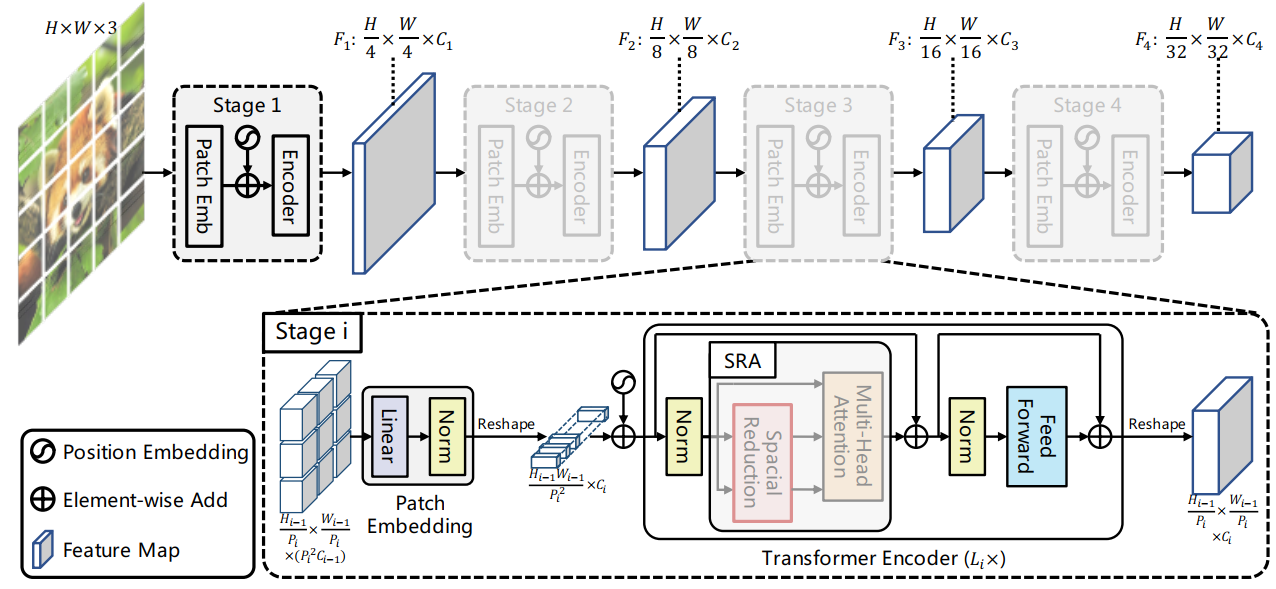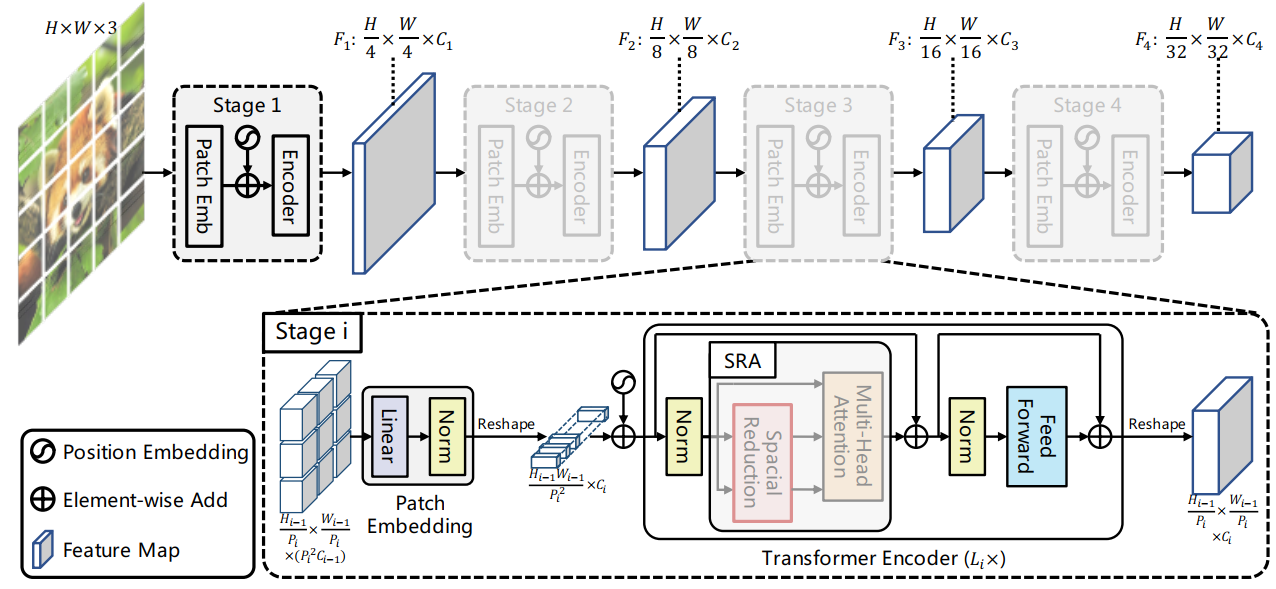)
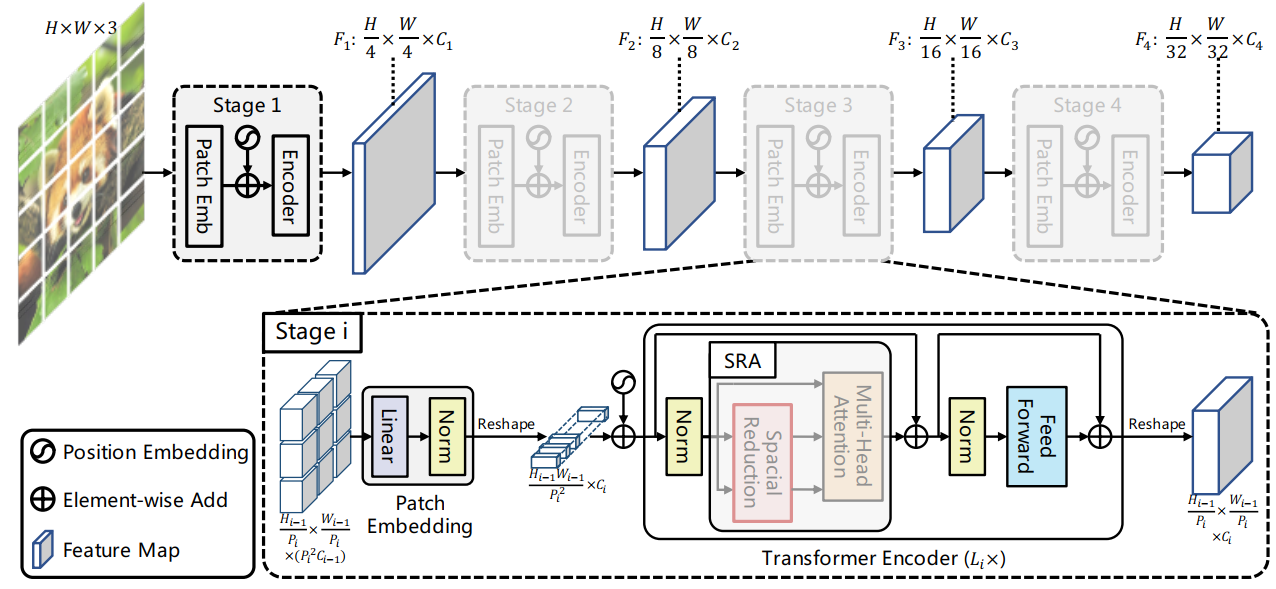
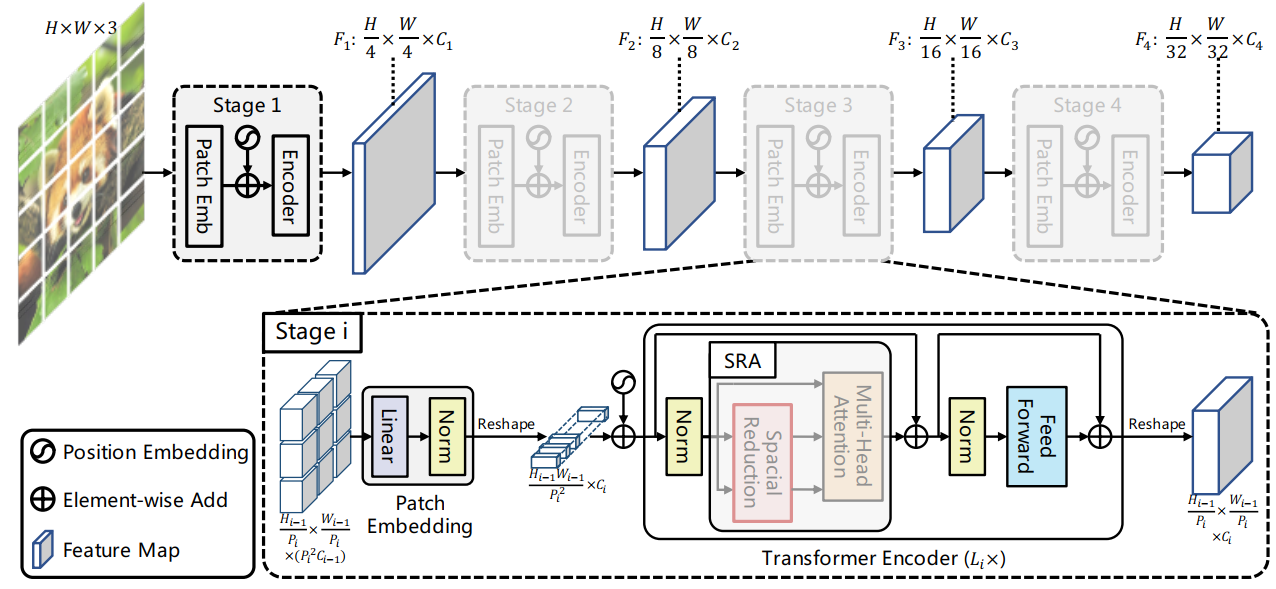
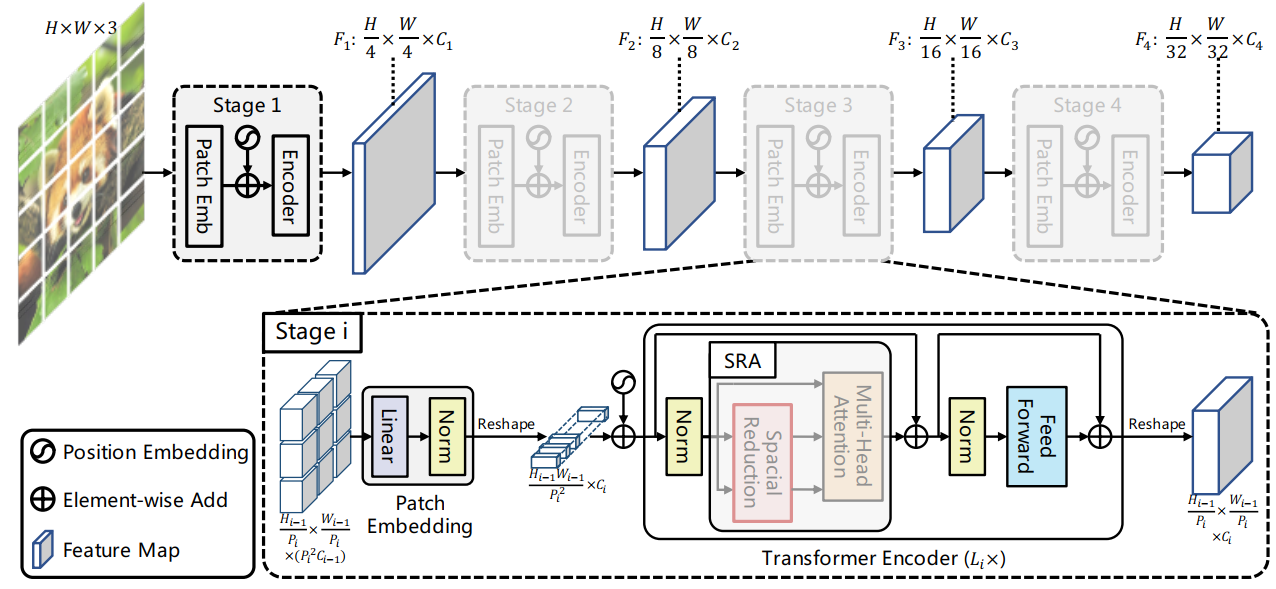
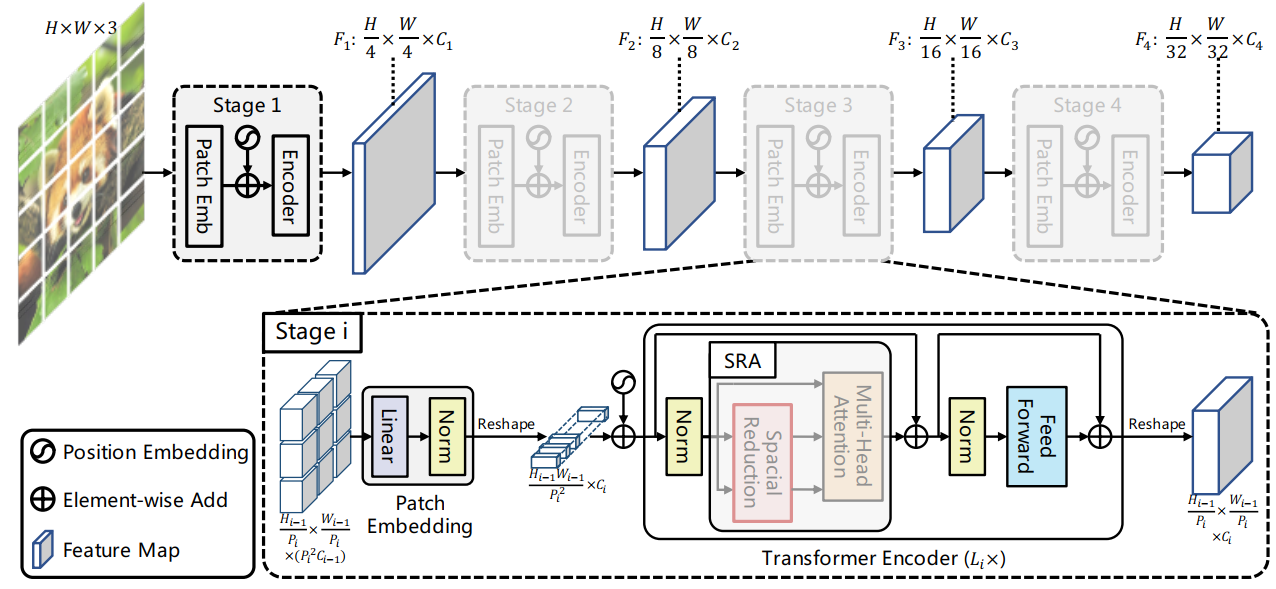

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0 # Import EfficientNetB0

# --- Helper Classes for Vision Transformer (No changes needed here) ---
class Patches(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_patches": self.num_patches,
            "projection_dim": self.projection_dim,
        })
        return config

class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], score.dtype)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(concat_attention)
        return output

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
        })
        return config

class MLP(layers.Layer):
    def __init__(self, mlp_units, dropout_rate, **kwargs):
        super().__init__(**kwargs)
        self.mlp_units = mlp_units
        self.dropout_rate = dropout_rate
        self.dense_layers = []
        for units in mlp_units:
            self.dense_layers.append(layers.Dense(units, activation=tf.nn.gelu))
        self.dropout = layers.Dropout(dropout_rate)

    def call(self, inputs):
        x = inputs
        for layer in self.dense_layers:
            x = layer(x)
        x = self.dropout(x)
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "mlp_units": self.mlp_units,
            "dropout_rate": self.dropout_rate,
        })
        return config

# --- Vision Transformer with EfficientNetB0 as Feature Extractor ---
def create_vit_efficientnet_classifier(
    input_shape,
    patch_size,
    projection_dim, # This argument is flexible, but will be overridden if None.
    transformer_layers,
    num_heads,
    mlp_head_units,
    num_classes,
    transformer_units=[256, 128],
    dropout_rate=0.1,
    efficientnet_trainable=False # Option to fine-tune EfficientNetB0
):
    inputs = layers.Input(shape=input_shape)

    # 1. Augmentation (applied before EfficientNetB0)
    # IMPORTANT: Removed layers.Normalization() as EfficientNet handles its own scaling
    augmented = tf.keras.Sequential([
        layers.Resizing(input_shape[0], input_shape[1]),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ], name="augmentation_layer")(inputs)

    # 2. EfficientNetB0 as a feature extractor
    efficientnet_model = EfficientNetB0(
        include_top=False,
        weights="imagenet", # Use pre-trained ImageNet weights
        input_tensor=augmented, # Pass augmented images directly
        input_shape=input_shape, # Match the input shape
        pooling=None # <--- Crucial fix: Ensures raw feature map output
    )
    efficientnet_model.trainable = efficientnet_trainable # Set trainable or not

    # Get features from EfficientNetB0's last convolutional block
    efficientnet_features = efficientnet_model.output

    # Calculate num_patches based on the EfficientNet output shape
    feature_map_shape = efficientnet_features.shape[1:3] # (H, W) of the feature map
    num_patches_eff = (feature_map_shape[0] // patch_size) * \
                      (feature_map_shape[1] // patch_size)

    # The projection_dim for PatchEncoder should ideally match the last dimension
    # of the patches_from_efficientnet, which is the channel dimension of EfficientNet's output.
    efficientnet_output_channels = efficientnet_features.shape[-1]
    patch_encoder_projection_dim = efficientnet_output_channels

    # 3. Encode patches from EfficientNet features
    patches_from_efficientnet = Patches(patch_size)(efficientnet_features)
    encoded_patches = PatchEncoder(num_patches_eff, patch_encoder_projection_dim)(patches_from_efficientnet)

    # 4. Create multiple Transformer blocks
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = MultiHeadSelfAttention(
            embed_dim=patch_encoder_projection_dim, num_heads=num_heads
        )(x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = MLP(transformer_units, dropout_rate)(x3)
        encoded_patches = layers.Add()([x3, x2])

    # 5. Global Average Pooling (after Transformer blocks)
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.GlobalAveragePooling1D()(representation)

    # 6. Add MLP head for classification (applied to the combined features)
    for units in mlp_head_units:
        representation = layers.Dense(units, activation=tf.nn.gelu)(representation)
        representation = layers.Dropout(dropout_rate)(representation)

    # Output layer
    logits = layers.Dense(num_classes)(representation)

    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=logits)
    return model

# --- Your existing setup code ---
dataset_path = "/kaggle/input/potato-leaf-disease-dataset/Potato Leaf Disease Dataset in Uncontrolled Environment"
img_size = (224,224) # Standard for EfficientNetB0
input_shape = img_size + (3,)
batch_size = 64
patch_size = 2 # This patch size now applies to the feature map, not the original image
              # A smaller patch size on the feature map is typical.
              # For example, if EfficientNet outputs 7x7, a patch_size of 1 or 2 is common.

transformer_layers = 4
num_heads = 4
mlp_head_units = [128, 64] # For the classification head

# Parameters for the Transformer MLP layers (within each transformer block)
efficientnet_b0_output_channels = 1280 # Standard for EfficientNetB0's last block output
transformer_units = [
    efficientnet_b0_output_channels * 2,
    efficientnet_b0_output_channels,
]
dropout_rate = 0.1 # General dropout rate

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.1,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.1,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
)
class_names = train_ds.class_names
num_classes = len(class_names)

# Optimize performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# --- Call the new create_vit_efficientnet_classifier and compile/train ---
# Corrected: All arguments after the first keyword argument must also be keyword arguments.
vit_model = create_vit_efficientnet_classifier(
    input_shape,
    patch_size,
    projection_dim=None, # This argument is dynamically determined inside the function now
    transformer_layers=transformer_layers,
    num_heads=num_heads,
    mlp_head_units=mlp_head_units,
    num_classes=num_classes,
    transformer_units=transformer_units,
    dropout_rate=dropout_rate,
    efficientnet_trainable=False # Set to True to fine-tune EfficientNetB0
)

# Print model summary to verify inputs
vit_model.summary()

# Compile model
vit_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# Train model
print("\nStarting model training...")
history = vit_model.fit( # Corrected variable name here
    train_ds,
    epochs=50,
    validation_data=val_ds,
)

# Evaluate model
test_loss, test_accuracy = vit_model.evaluate(val_ds) # Corrected variable name here
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

## Ensemble Methods

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- SOLUTION 1: Resize validation dataset to match model input ---
print("--- Solution 1: Resizing validation dataset ---")

def resize_dataset(dataset, target_size=(256, 256)):
    """Resize images in dataset to target size"""
    def resize_function(image, label):
        # Resize image to target size
        image = tf.image.resize(image, target_size)
        return image, label
    
    return dataset.map(resize_function, num_parallel_calls=tf.data.AUTOTUNE)

# Create resized validation dataset for DenseNet
val_ds_256 = resize_dataset(val_ds, target_size=(256, 256))

# --- SOLUTION 2: Create separate datasets for each model ---
print("--- Solution 2: Creating model-specific datasets ---")

# For DenseNet (256x256)
val_ds_densenet = resize_dataset(val_ds, target_size=(256, 256))

# For ViT (assuming it uses 224x224, keep original or resize as needed)
val_ds_vit = val_ds  # Keep original if ViT uses 224x224
# val_ds_vit = resize_dataset(val_ds, target_size=(224, 224))  # Uncomment if needed

# --- SOLUTION 3: Dynamic resizing during prediction ---
print("--- Solution 3: Dynamic resizing approach ---")

def predict_with_resize(model, dataset, target_size):
    """Predict with dynamic resizing"""
    predictions = []
    
    for batch in dataset:
        if isinstance(batch, tuple):
            images, labels = batch
        else:
            images = batch
            
        # Resize images to match model input
        resized_images = tf.image.resize(images, target_size)
        
        # Get predictions
        batch_predictions = model.predict(resized_images, verbose=0)
        predictions.append(batch_predictions)
    
    return np.concatenate(predictions, axis=0)

# --- MAIN ENSEMBLE CODE WITH FIXES ---
print("--- Starting Ensemble Prediction with Input Size Fix ---")

# Method 1: Use resized datasets
try:
    print("Getting DenseNet predictions (256x256)...")
    densenet_probs = model.predict(val_ds_256)
    
    print("Getting ViT predictions (224x224)...")
    vit_probs = vit_model.predict(val_ds_vit)
    
except Exception as e:
    print(f"Error with method 1: {e}")
    print("Trying dynamic resizing approach...")
    
    # Method 2: Use dynamic resizing
    try:
        print("Getting DenseNet predictions with dynamic resizing...")
        densenet_probs = predict_with_resize(model, val_ds, target_size=(256, 256))
        
        print("Getting ViT predictions...")
        vit_probs = predict_with_resize(vit_model, val_ds, target_size=(224, 224))
        
    except Exception as e2:
        print(f"Error with dynamic resizing: {e2}")
        print("Please check your model architectures and input requirements")
        raise

# Convert to probabilities if needed
if densenet_probs.max() > 1.0 or densenet_probs.min() < 0.0:
    densenet_probs = tf.nn.softmax(densenet_probs, axis=-1).numpy()
    
if vit_probs.max() > 1.0 or vit_probs.min() < 0.0:
    vit_probs = tf.nn.softmax(vit_probs, axis=-1).numpy()

print("Creating ensemble predictions...")
# Simple averaging ensemble
ensemble_probs = (densenet_probs + vit_probs) / 2

# Get predicted classes for the ensemble
ensemble_predictions = np.argmax(ensemble_probs, axis=1)

# Get true labels from the validation dataset
print("Extracting true labels...")
true_labels = []

for batch in val_ds:
    if isinstance(batch, tuple) and len(batch) == 2:
        images, labels = batch
        # Handle different label formats
        if len(labels.shape) > 1:  # One-hot encoded
            labels = tf.argmax(labels, axis=1)
        true_labels.extend(labels.numpy())
    else:
        print("Warning: Unexpected batch structure")
        break

true_labels = np.array(true_labels)

# Verify dimensions match
print(f"Number of predictions: {len(ensemble_predictions)}")
print(f"Number of true labels: {len(true_labels)}")

if len(ensemble_predictions) != len(true_labels):
    print("Warning: Mismatch between predictions and labels count!")
    min_len = min(len(ensemble_predictions), len(true_labels))
    ensemble_predictions = ensemble_predictions[:min_len]
    true_labels = true_labels[:min_len]
    print(f"Truncated to {min_len} samples")

# Get unique classes
unique_classes = np.unique(true_labels)

# Evaluate Ensemble Performance
print("\n" + "="*50)
print("ENSEMBLE RESULTS")
print("="*50)

print("\nEnsemble Classification Report:")
print(classification_report(true_labels, ensemble_predictions, 
                          target_names=[f'Class {i}' for i in unique_classes]))

print("\nEnsemble Confusion Matrix:")
cm = confusion_matrix(true_labels, ensemble_predictions)
print(cm)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Class {i}' for i in unique_classes],
            yticklabels=[f'Class {i}' for i in unique_classes])
plt.title('Ensemble Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Calculate accuracies
accuracy = np.sum(ensemble_predictions == true_labels) / len(true_labels)
densenet_predictions = np.argmax(densenet_probs, axis=1)
vit_predictions = np.argmax(vit_probs, axis=1)

densenet_accuracy = np.sum(densenet_predictions == true_labels) / len(true_labels)
vit_accuracy = np.sum(vit_predictions == true_labels) / len(true_labels)

print(f"\nDenseNet Accuracy: {densenet_accuracy:.4f} ({densenet_accuracy*100:.2f}%)")
print(f"ViT Accuracy: {vit_accuracy:.4f} ({vit_accuracy*100:.2f}%)")
print(f"Ensemble Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

improvement = accuracy - max(densenet_accuracy, vit_accuracy)
print(f"Ensemble Improvement: {improvement:.4f} ({improvement*100:.2f}%)")

print("--- Ensemble Prediction Complete ---")

# --- ALTERNATIVE: Check model input requirements ---
print("\n" + "="*50)
print("MODEL INPUT REQUIREMENTS")
print("="*50)

print("DenseNet expected input shape:", model.input_shape)
print("ViT expected input shape:", vit_model.input_shape)

# Check actual dataset image shape
for batch in val_ds.take(1):
    if isinstance(batch, tuple):
        images, labels = batch
        print("Actual dataset image shape:", images.shape)
        break

## Adding more changes(SHAP)
